In [30]:
import pandas as pd
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

#### __Team Name:__ Nameless
__Members:__ Neil Bango, Adrian Kong, Vu Le

### __Title:__ When and where do CMIP6 scenarios cross the Paris 1.5°C and 2.0°C warming thresholds?

__Chosen dataset:__ Coupled Model Intercomparison Project (CMIP6)

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [19]:
model = "GFDL-ESM4"  # try "MPI-ESM1-2-HR" or "UKESM1-0-LL" if some experiments are missing
experiments = ["historical","ssp126","ssp245","ssp370","ssp585"]
grids = ["gr","gr1","gr2","gn"]  # prefer gr/gr1, allow gn as fallback
member = "r1i1p1f1"

subset = df.query(
    "table_id == 'Amon' and variable_id == 'tas' and "
    "experiment_id in ['historical','ssp126','ssp245','ssp370','ssp585'] and "
    "activity_id in ['CMIP','ScenarioMIP'] and "
    "source_id == @model and "
    "member_id == 'r1i1p1f1' and "
    "grid_label in ['gr','gr1','gr2','gn']"
)[["source_id","experiment_id","table_id","variable_id","grid_label","zstore"]].copy()
subset

,source_id,experiment_id,table_id,variable_id,grid_label,zstore
13327,GFDL-ESM4,ssp370,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
15454,GFDL-ESM4,ssp245,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
15886,GFDL-ESM4,ssp126,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
19008,GFDL-ESM4,ssp585,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
244695,GFDL-ESM4,historical,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...


In [20]:
rank = {g:i for i,g in enumerate(["gr","gr1","gr2","gn"])}
subset["grid_rank"] = subset["grid_label"].map(rank).fillna(99)
subset = (subset.sort_values(["experiment_id","grid_rank"])
                .drop_duplicates(subset=["experiment_id"], keep="first"))

if subset["experiment_id"].nunique() < len(experiments):
    print("⚠️ Not all experiments found for this model; found:", subset["experiment_id"].unique().tolist())

In [14]:
def open_cmip6(z):
    try:
        return xr.open_zarr(z, storage_options={"token":"anon"}, consolidated=True)
    except Exception:
        return xr.open_zarr(z, storage_options={"token":"anon"}, consolidated=False)

ds_by_exp = {row.experiment_id: open_cmip6(row.zstore) for _, row in subset.iterrows()}
list(ds_by_exp)

['ssp370', 'ssp245', 'ssp126', 'ssp585', 'historical']

In [21]:
ds_by_exp = {row.experiment_id: open_cmip6(row.zstore) for _, row in subset.iterrows()}
print("Opened datasets:", list(ds_by_exp.keys()))

Opened datasets: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']


In [116]:
import numpy as np
import xarray as xr

def area_weighted_global_mean(da):
    """Global mean weighted by cos(lat)."""
    w_lat = np.cos(np.deg2rad(da["lat"]))
    W = xr.DataArray(w_lat, dims=["lat"]).broadcast_like(da.isel(time=0))
    return (da * W).sum(dim=("lat", "lon")) / W.sum(dim=("lat", "lon"))

def global_mean_over_time_xr(ds):
    """Return xarray DataArray of global mean annual temps (°C), CFTime-safe."""
    tasC = ds["tas"] - 273.15
    ann  = tasC.resample(time="YE").mean()          # <-- 'YE' (Year-End) instead of 'Y'
    gm   = area_weighted_global_mean(ann)           # (time,)
    return gm

baseline_start, baseline_end = "1850", "1900"

print("\n=== CMIP6 Global Mean Surface Temperatures (°C) ===")
for name, ds in ds_by_exp.items():
    try:
        gm = global_mean_over_time_xr(ds)                       # xarray DataArray
        # overall mean for this dataset's time coverage
        overall_mean = float(gm.mean().values)

        # dataset time range (CFTime-safe)
        y_min = int(gm["time"].dt.year.min().values)
        y_max = int(gm["time"].dt.year.max().values)
        time_range = f"{y_min}-{y_max}"

        # 1850–1900 baseline (if available for this dataset)
        base = gm.sel(time=slice(baseline_start, baseline_end))
        if base.sizes.get("time", 0) > 0:
            base_mean = float(base.mean().values)
            base_str  = f"{base_mean:.2f}"
        else:
            base_str  = "N/A"

        print(f"{name:10s} | Range {time_range:>11s} | Baseline 1850–1900: {base_str:>6s} °C | Overall Mean: {overall_mean:.2f} °C")

    except Exception as e:
        print(f"{name:10s} | Range       error | Baseline 1850–1900:   N/A °C | Overall Mean: nan °C  (error: {e})")



=== CMIP6 Global Mean Surface Temperatures (°C) ===
historical | Range   1850-2014 | Baseline 1850–1900:  13.41 °C | Overall Mean: 13.59 °C
ssp126     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 14.75 °C
ssp245     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 15.12 °C
ssp370     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 15.51 °C
ssp585     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 15.72 °C


Basically the Paris Agreement is an agreement from countries over the world to lower their pollution. They have 2 goals: an ambitious goal of limiting global warming to  below 1.5°C above pre-industrial levels and a more realistic goal of limiting it below 2°C above pre-industrial levels. (I used this source https://www.climate.gov/news-features/features/whats-number-meaning-15-c-climate-threshold that says pre-industrial is between 1850-1900).

The dataset we have gave a prediction of the temperature between 1850-1900, so that is our baseline. It also has 4 simulations, each with a different level of severity of emissions: "ssp585": "SSP5-8.5 – (Very High Emissions)",  "ssp370": "SSP3-7.0 – (High Emissions)", "ssp245": "SSP2-4.5 – (Middle Emissions)", "ssp126": "SSP1-2.6 – (Low Emissions)". Basically I want to do an end goal of a world map where you can look at what places fail the paris agreement based on the simulation.

Temperature anomaly: the difference between the temperature and the pre-industrial average. Let's say the temperature is like 18 Celsius right now and the pre-industrial average is 17 Celsius, then the temperature anomaly would be 1 degree Celsius.

We are using Near-surface air temperature as the variable for temperature.

### Graph 1

In [24]:
def to_celsius(da): return da - 273.15

def annual_mean(da): return da.resample(time="1Y").mean()

def anomalies_vs_baseline(da_ann, base_start="1850", base_end="1900"):
    base = da_ann.sel(time=slice(base_start, base_end)).mean("time")
    if np.isnan(base).all():  # fallback if early years missing
        base = da_ann.isel(time=slice(0, min(50, da_ann.sizes["time"]))).mean("time")
    return da_ann - base

def global_mean_weighted(da):
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return (da * w).mean(("lat","lon"))

def first_crossing_year(d, thresh):
    d = d.sort_values("year")
    y, t = d["anom_degC"].values, d["year"].values
    above = y >= thresh
    if not above.any(): return np.nan
    i = np.argmax(above)
    if i == 0: return float(t[0])
    x0,x1 = t[i-1], t[i]; y0,y1 = y[i-1], y[i]
    if y1 == y0: return float(x1)
    return float(x0 + (thresh - y0) * (x1 - y0) / (y1 - y0))

In [33]:
rows = []
for exp, ds in ds_by_exp.items():
    if exp.startswith("ssp"):           # <-- ignore 'historical'
        tas  = to_celsius(ds["tas"])
        ann  = annual_mean(tas)
        anom = anomalies_vs_baseline(ann)
        gmean = global_mean_weighted(anom).rename("anom_degC")

        out = gmean.to_series().reset_index(name="anom_degC")
        out["year"] = [t.year for t in out["time"]]
        out["scenario"] = exp
        rows.append(out[["year","scenario","anom_degC"]])

globals_df = pd.concat(rows, ignore_index=True)
globals_df = globals_df[globals_df["year"] >= 2015]  # start from 2015
globals_df = globals_df.sort_values(["scenario","year"])



<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


In [34]:
globals_df

,year,scenario,anom_degC
0,2015,ssp126,-0.491735
1,2016,ssp126,-0.424989
2,2017,ssp126,-0.250540
3,2018,ssp126,-0.442872
4,2019,ssp126,-0.344514
...,...,...,...
339,2096,ssp585,2.423069
340,2097,ssp585,2.209318
341,2098,ssp585,2.507928
342,2099,ssp585,2.703012


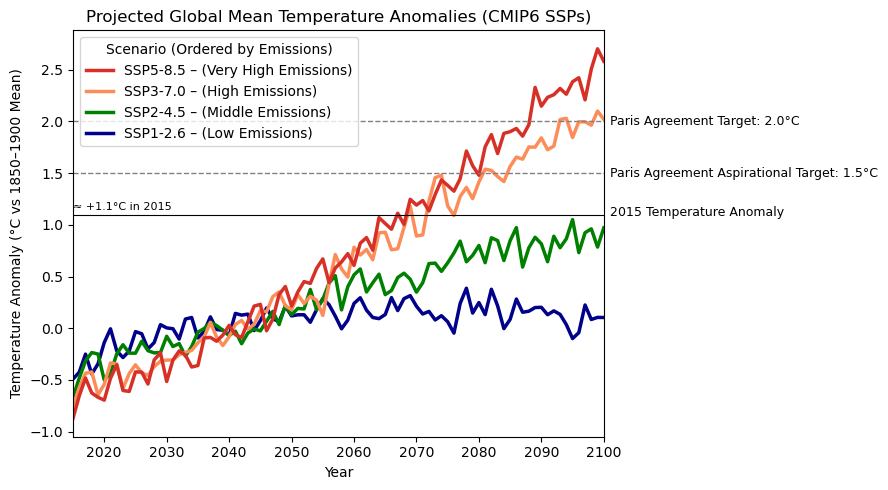

In [ ]:
ssp_labels = {
    "ssp585": "SSP5-8.5 – (Very High Emissions)",
    "ssp370": "SSP3-7.0 – (High Emissions)",
    "ssp245": "SSP2-4.5 – (Middle Emissions)",
    "ssp126": "SSP1-2.6 – (Low Emissions)"
}

# High → low emissions order
plot_order = ["ssp585", "ssp370", "ssp245", "ssp126"]

# Custom color map (red → orange → green → blue-green)
ssp_colors = {
    "ssp585": "#d73027",  # red
    "ssp370": "#fc8d59",  # orange
    "ssp245": "#008000",  # green
    "ssp126": "#00008B"   # blue-green
}

plt.figure(figsize=(9,5))

# Plot each SSP with its own color
for scen, d in globals_df.groupby("scenario"):
    label = ssp_labels.get(scen, scen)
    color = ssp_colors.get(scen, "gray")
    plt.plot(d["year"], d["anom_degC"], label=label, linewidth=2.5, color=color)

# Paris Agreement thresholds
plt.axhline(1.5, linestyle="--", color="gray", linewidth=1, label=None)
plt.axhline(2.0, linestyle="--", color="gray", linewidth=1, label=None)
plt.text(2101, 1.5, "Paris Agreement Aspirational Target: 1.5°C", va="center", fontsize=9)
plt.text(2101, 2.0, "Paris Agreement Target: 2.0°C", va="center", fontsize=9)

# Current warming marker
plt.axhline(1.1, color="black", linewidth=0.8, label=None)
plt.text(2015, 1.12, "≈ +1.1°C in 2015", va="bottom", ha="left", fontsize=8)
plt.text(2101, 1.12, "2015 Temperature Anomaly", va="center", fontsize=9)

plt.xlim(2015, 2100)
plt.title("Projected Global Mean Temperature Anomalies (CMIP6 SSPs)")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (Year Mean Temperature (°C) - (1850–1900 Temperature Mean))")

# --- Custom legend (High → Low) ---
handles, labels = plt.gca().get_legend_handles_labels()
ordered = [labels.index(ssp_labels[k]) for k in plot_order if ssp_labels.get(k) in labels]
plt.legend(
    [handles[i] for i in ordered],
    [labels[i] for i in ordered],
    title="Scenario (Ordered by Emissions)",
    loc="upper left"
)

plt.tight_layout()
plt.show()



=== CMIP6 Global Mean Surface Temperatures (°C) ===
historical | Range   1850-2014 | Baseline 1850–1900:  13.41 °C | Overall Mean: 13.59 °C
ssp126     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 14.75 °C
ssp245     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 15.12 °C
ssp370     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 15.51 °C
ssp585     | Range   2015-2100 | Baseline 1850–1900:    N/A °C | Overall Mean: 15.72 °C


This graph is showing the temperature anomaly based on the different simulations and year. As you can see, the two best scenario situations show that we will reach our goal of being under 1.5 degrees of the temperature anomaly, but in the other two we will not. As of 2015, the temperature anomaly was 1.1 degrees Celsius, which means we are already doing worse than all the simulations from the dataset.

### Graph 2

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


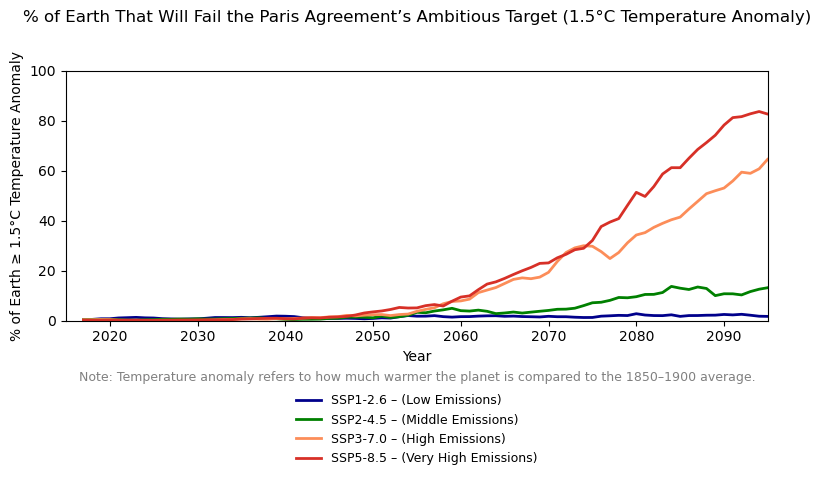

In [104]:
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt

# --- helpers ---
def to_celsius(da): return da - 273.15
def annual_mean(da): return da.resample(time="1Y").mean()
def anomalies_vs_baseline(da_ann, base_start="1850", base_end="1900"):
    base = da_ann.sel(time=slice(base_start, base_end)).mean("time")
    if xr.apply_ufunc(np.isnan, base).all():
        base = da_ann.isel(time=slice(0, min(50, da_ann.sizes["time"]))).mean("time")
    return da_ann - base

def annual_anomaly_field(ds):
    tas = to_celsius(ds["tas"])
    ann = annual_mean(tas)
    return anomalies_vs_baseline(ann)

def latlon_area_weights_like(da):
    lat = da["lat"]
    w_lat = np.cos(np.deg2rad(lat))
    w_lat = w_lat / w_lat.mean()
    W = xr.DataArray(w_lat, dims=("lat",)).broadcast_like(da.isel(time=0))
    return W

def fraction_over_threshold_over_time(anom_field, threshold):
    W = latlon_area_weights_like(anom_field)
    over = (anom_field >= threshold)
    num = (over * W).sum(dim=("lat","lon"))
    den = W.sum(dim=("lat","lon"))
    frac = (num / den).compute()
    years = frac["time"].dt.year.values
    return pd.DataFrame({"year": years, "fraction_over": frac.values})

def fraction_over_threshold_future_only(ds_future, threshold):
    anom = annual_anomaly_field(ds_future)
    anom = anom.sel(time=slice("2015","2100"))
    return fraction_over_threshold_over_time(anom, threshold)

# --- custom SSP colors + labels ---
ssp_colors = {
    "ssp585": "#d73027",  # red
    "ssp370": "#fc8d59",  # orange
    "ssp245": "#008000",  # green
    "ssp126": "#00008B"   # blue
}

ssp_labels = {
    "ssp585": "SSP5-8.5 – (Very High Emissions)",
    "ssp370": "SSP3-7.0 – (High Emissions)",
    "ssp245": "SSP2-4.5 – (Middle Emissions)",
    "ssp126": "SSP1-2.6 – (Low Emissions)"
}

# --- main plot ---
threshold = 1.5
scenarios = ["ssp126", "ssp245", "ssp370", "ssp585"]

plt.figure(figsize=(9,5))
for scen in scenarios:
    if scen in ds_by_exp:
        df = fraction_over_threshold_future_only(ds_by_exp[scen], threshold)
        y = df["fraction_over"].rolling(5, center=True).mean() * 100
        plt.plot(
            df["year"], y,
            label=ssp_labels[scen],
            linewidth=2,
            color=ssp_colors[scen]
        )

# --- axis + title ---
plt.xlim(2015, 2095)
plt.ylim(0, 100)
plt.xlabel("Year", fontsize=10)
plt.ylabel("% of Earth ≥ 1.5°C Temperature Anomaly", fontsize=10)
plt.title("% of Earth That Will Fail the Paris Agreement’s Ambitious Target (1.5°C Temperature Anomaly)",
          fontsize=12, pad=35)

# --- explanatory note below the graph ---
plt.text(
    0.5, -0.2,
    "Note: Temperature anomaly refers to how much warmer the planet is compared to the 1850–1900 average.",
    ha="center", va="top", fontsize=9, color="gray", transform=plt.gca().transAxes
)

# --- legend below ---
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=1,                 # one column for readability since labels are long
    frameon=False,
    fontsize=9
)

# --- layout tuning ---
plt.subplots_adjust(left=0.12, bottom=0.4, top=0.9)
plt.grid(False)
plt.show()


This graph shows the percent of Earth that will fail the ambitious target of less than 1.5 degrees temperature anomaly based on simulation and time.

### Graph 3

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


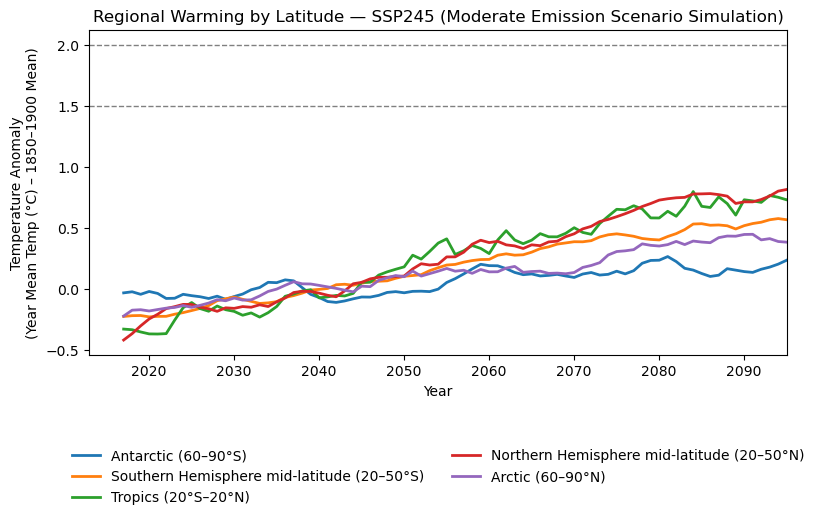

In [94]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import xarray as xr

# --- helpers (paste once if not already defined) ---
def to_celsius(da): return da - 273.15
def annual_mean(da): return da.resample(time="1Y").mean()
def anomalies_vs_baseline(da_ann, base_start="1850", base_end="1900"):
    base = da_ann.sel(time=slice(base_start, base_end)).mean("time")
    if xr.apply_ufunc(np.isnan, base).all():
        base = da_ann.isel(time=slice(0, min(50, da_ann.sizes["time"]))).mean("time")
    return da_ann - base

# pick a scenario to illustrate regional differences
target_scen = "ssp245"   # change to 'ssp126'/'ssp370'/'ssp585' if you want
ds = ds_by_exp[target_scen]

def band_series(ds, lat_min, lat_max):
    tas  = to_celsius(ds["tas"])
    ann  = annual_mean(tas)
    anom = anomalies_vs_baseline(ann)
    sub  = anom.sel(lat=slice(lat_min, lat_max))
    w    = np.cos(np.deg2rad(sub["lat"]))
    s = (sub * w).mean(("lat","lon")).to_series().reset_index(name="anom_degC")
    s["year"] = [t.year for t in s["time"]]
    return s[["year","anom_degC"]]

bands = {
    "Antarctic (60–90°S)": (-90, -60),
    "Southern Hemisphere mid-latitude (20–50°S)":   (-50, -20),
    "Tropics (20°S–20°N)": (-20, 20),
    "Northern Hemisphere mid-latitude (20–50°N)":    (20, 50),
    "Arctic (60–90°N)":    (60, 90),
}

plt.figure(figsize=(9,5))
for name, (a,b) in bands.items():
    s = band_series(ds, a, b)
    y = s["anom_degC"].rolling(5, center=True).mean()
    plt.plot(s["year"], y, label=name, linewidth=2)

plt.axhline(1.5, linestyle="--", color="gray", linewidth=1)
plt.axhline(2.0, linestyle="--", color="gray", linewidth=1)
plt.title(f"Regional Warming by Latitude — {target_scen.upper()} (Moderate Emission Scenario Simulation)")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly\n(Year Mean Temp (°C) – 1850–1900 Mean)")

# Legend below
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    frameon=False
)

# Instead of plt.show(), use savefig or adjust layout first
plt.savefig("regional_warming.png", bbox_inches="tight")  # ensures legend included
plt.xlim(None, 2095)
plt.subplots_adjust(bottom=0.25, top=0.9)
plt.show()


This graph shows the temperature anomaly based on latitude throughout the years. The northern hemisphere mid-latitude seems to have the most and that may be due to Europe, North America, and Asia, areas that have a lot of pollution. 

### Graph 4

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


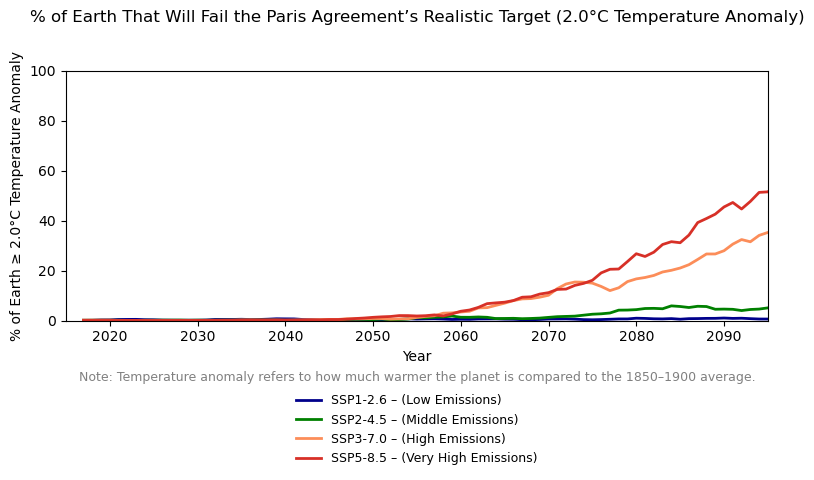

In [105]:
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt

# --- helpers ---
def to_celsius(da): return da - 273.15
def annual_mean(da): return da.resample(time="1Y").mean()
def anomalies_vs_baseline(da_ann, base_start="1850", base_end="1900"):
    base = da_ann.sel(time=slice(base_start, base_end)).mean("time")
    if xr.apply_ufunc(np.isnan, base).all():
        base = da_ann.isel(time=slice(0, min(50, da_ann.sizes["time"]))).mean("time")
    return da_ann - base

def annual_anomaly_field(ds):
    tas = to_celsius(ds["tas"])
    ann = annual_mean(tas)
    return anomalies_vs_baseline(ann)

def latlon_area_weights_like(da):
    lat = da["lat"]
    w_lat = np.cos(np.deg2rad(lat))
    w_lat = w_lat / w_lat.mean()
    W = xr.DataArray(w_lat, dims=("lat",)).broadcast_like(da.isel(time=0))
    return W

def fraction_over_threshold_over_time(anom_field, threshold):
    W = latlon_area_weights_like(anom_field)
    over = (anom_field >= threshold)
    num = (over * W).sum(dim=("lat","lon"))
    den = W.sum(dim=("lat","lon"))
    frac = (num / den).compute()
    years = frac["time"].dt.year.values
    return pd.DataFrame({"year": years, "fraction_over": frac.values})

def fraction_over_threshold_future_only(ds_future, threshold):
    anom = annual_anomaly_field(ds_future)
    anom = anom.sel(time=slice("2015","2100"))
    return fraction_over_threshold_over_time(anom, threshold)

# --- custom SSP colors + labels ---
ssp_colors = {
    "ssp585": "#d73027",  # red
    "ssp370": "#fc8d59",  # orange
    "ssp245": "#008000",  # green
    "ssp126": "#00008B"   # blue
}

ssp_labels = {
    "ssp585": "SSP5-8.5 – (Very High Emissions)",
    "ssp370": "SSP3-7.0 – (High Emissions)",
    "ssp245": "SSP2-4.5 – (Middle Emissions)",
    "ssp126": "SSP1-2.6 – (Low Emissions)"
}

# --- main plot (Realistic Target: 2.0°C) ---
threshold = 2.0
scenarios = ["ssp126", "ssp245", "ssp370", "ssp585"]

plt.figure(figsize=(9,5))
for scen in scenarios:
    if scen in ds_by_exp:
        df = fraction_over_threshold_future_only(ds_by_exp[scen], threshold)
        y = df["fraction_over"].rolling(5, center=True).mean() * 100
        plt.plot(
            df["year"], y,
            label=ssp_labels[scen],
            linewidth=2,
            color=ssp_colors[scen]
        )

# --- axis + title ---
plt.xlim(2015, 2095)
plt.ylim(0, 100)
plt.xlabel("Year", fontsize=10)
plt.ylabel("% of Earth ≥ 2.0°C Temperature Anomaly", fontsize=10)
plt.title("% of Earth That Will Fail the Paris Agreement’s Realistic Target (2.0°C Temperature Anomaly)",
          fontsize=12, pad=35)

# --- explanatory note below the graph ---
plt.text(
    0.5, -0.2,
    "Note: Temperature anomaly refers to how much warmer the planet is compared to the 1850–1900 average.",
    ha="center", va="top", fontsize=9, color="gray", transform=plt.gca().transAxes
)

# --- legend below ---
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=1,                 # one column for readability since labels are long
    frameon=False,
    fontsize=9
)

# --- layout tuning ---
plt.subplots_adjust(left=0.12, bottom=0.4, top=0.9)
plt.grid(False)
plt.show()


This graph shows the percent of Earth that will fail the  target of less than 2.0 degrees temperature anomaly based on simulation and time.

### Graph 5

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


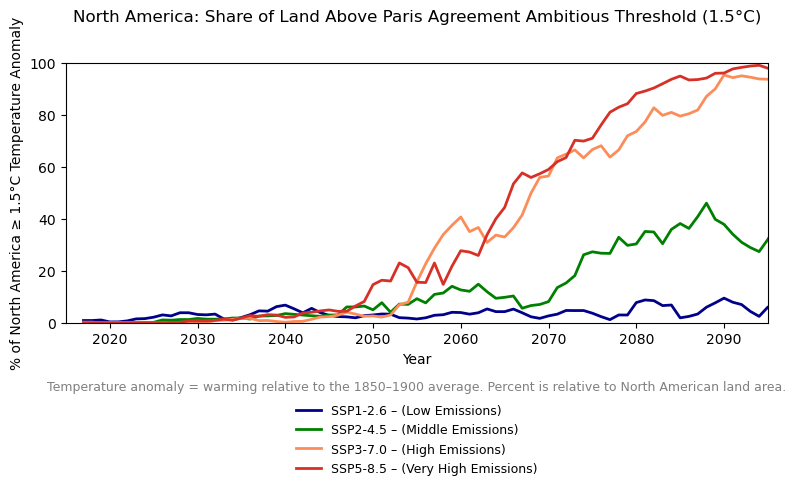

In [111]:
# !pip -q install geopandas regionmask shapely

import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
import geopandas as gpd, regionmask

# ---------- helpers ----------
def to_celsius(da): return da - 273.15
def annual_mean(da): return da.resample(time="1Y").mean()
def anomalies_vs_baseline(da_ann, base_start="1850", base_end="1900"):
    base = da_ann.sel(time=slice(base_start, base_end)).mean("time")
    if xr.apply_ufunc(np.isnan, base).all():
        base = da_ann.isel(time=slice(0, min(50, da_ann.sizes["time"]))).mean("time")
    return da_ann - base

def annual_anomaly_field(ds):
    tas = to_celsius(ds["tas"])
    ann = annual_mean(tas)
    return anomalies_vs_baseline(ann)

def latlon_area_weights_like(da):
    lat = da["lat"]
    w_lat = np.cos(np.deg2rad(lat))
    return xr.DataArray(w_lat, dims=("lat",)).broadcast_like(da.isel(time=0))  # (lat, lon)

def continents_mask_like(da_latlon):
    """Build continent regions & mask aligned to (lat,lon)."""
    world = gpd.read_file(
        "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
    ).to_crs(epsg=4326).dropna(subset=["CONTINENT"])
    cont = world.dissolve(by="CONTINENT", as_index=False)[["CONTINENT", "geometry"]]
    cont = cont.rename(columns={"CONTINENT": "name"})
    reg = regionmask.Regions(
        names=cont["name"].tolist(),
        outlines=cont["geometry"].values,
        numbers=list(range(len(cont)))
    )
    mask = reg.mask(da_latlon)  # auto-detects lat/lon names
    return reg, mask

def fraction_over_threshold_region(anom, mask_region_bool, threshold):
    """
    anom: (time, lat, lon) anomaly °C
    mask_region_bool: (lat, lon) True for cells inside the region
    Returns DataFrame with columns: year, fraction_over (0..1) relative to region area
    """
    W = latlon_area_weights_like(anom)                       # (lat, lon)
    W_reg = W.where(mask_region_bool)                        # region weights
    denom = W_reg.sum(dim=("lat","lon"))                     # scalar (region area)
    over = (anom >= threshold)                               # (time, lat, lon)
    num = (over * W_reg).sum(dim=("lat","lon"))              # (time,)
    frac = (num / denom).compute()
    years = frac["time"].dt.year.values                      # works with cftime
    return pd.DataFrame({"year": years, "fraction_over": frac.values})

def ssp_only_fraction_for_region(ds_future, mask_region_bool, threshold):
    anom = annual_anomaly_field(ds_future).sel(time=slice("2015","2100"))
    return fraction_over_threshold_region(anom, mask_region_bool, threshold)

# ---------- your colors + labels ----------
ssp_colors = {
    "ssp585": "#d73027",  # red
    "ssp370": "#fc8d59",  # orange
    "ssp245": "#008000",  # green
    "ssp126": "#00008B"   # blue
}
ssp_labels = {
    "ssp585": "SSP5-8.5 – (Very High Emissions)",
    "ssp370": "SSP3-7.0 – (High Emissions)",
    "ssp245": "SSP2-4.5 – (Middle Emissions)",
    "ssp126": "SSP1-2.6 – (Low Emissions)"
}

# ---------- build North America mask on your grid ----------
# Use any scenario dataset just to get the grid for masking:
_any_ds = next(iter(ds_by_exp.values()))
_da_grid = (_any_ds["tas"].isel(time=0) - 273.15)  # dummy field to carry lat/lon

regions, mask = continents_mask_like(_da_grid)     # mask: (lat, lon) with region IDs
# Find the index for "North America"
NA_idx = [i for i, n in enumerate(regions.names) if n == "North America"]
if not NA_idx:
    raise ValueError("Could not find 'North America' in continent names: " + str(regions.names))
NA_mask = (mask == NA_idx[0])                      # boolean region mask

# ---------- compute & plot (choose your target) ----------
threshold = 1.5   # use 2.0 for the "realistic" target
scenarios = ["ssp126","ssp245","ssp370","ssp585"]

plt.figure(figsize=(9,5))
for scen in scenarios:
    if scen in ds_by_exp:
        df = ssp_only_fraction_for_region(ds_by_exp[scen], NA_mask, threshold)
        y = df["fraction_over"].rolling(5, center=True).mean() * 100
        plt.plot(df["year"], y, label=ssp_labels[scen], color=ssp_colors[scen], linewidth=2)

plt.xlim(2015, 2095)
plt.ylim(0, 100)
plt.xlabel("Year", fontsize=10)
plt.ylabel(f"% of North America ≥ {threshold}°C Temperature Anomaly", fontsize=10)
plt.title(f"North America: Share of Land Above Paris Agreement Ambitious Threshold ({threshold}°C)",
          fontsize=12, pad=30)

# note & legend below
plt.text(
    0.5, -0.22,
    "Temperature anomaly = warming relative to the 1850–1900 average. Percent is relative to North American land area.",
    ha="center", va="top", fontsize=9, color="gray", transform=plt.gca().transAxes
)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.27), ncol=1, frameon=False, fontsize=9)

plt.subplots_adjust(left=0.12, bottom=0.38, top=0.9)
plt.grid(False)
plt.show()


This shows the percent of North America that will be above the ambitious goal of 1.5 degrees temperature anomaly. In the two worse situations, almost all the entirety of North America will fail the goal.

Plan for the final dynamic graph:

- World Map SVG
- Overlay with d3.js stuff
- ???
- Profit

### I dont know what

In [4]:
experiments = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
variable   = "tas"     # near-surface air temperature
table      = "Amon"    # monthly atmospheric
model      = "GFDL-ESM4"  # try "MPI-ESM1-2-HR", "UKESM1-0-LL" if needed
members    = ["r1i1p1f1", "r2i1p1f1"]  # fallback list if first not present
grids      = ["gn", "gr", "gr1", "gr2"] # allow native or regridded

# Filter to candidates
cand = df[
    (df["variable_id"]==variable) &
    (df["table_id"]==table) &
    (df["source_id"]==model) &
    (df["experiment_id"].isin(experiments)) &
    (df["member_id"].isin(members)) &
    (df["grid_label"].isin(grids))
].copy()

In [5]:
cand

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
1766,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
12516,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r2i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
13327,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
15454,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
15886,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp126,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
19008,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
244695,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


In [6]:
grid_rank = {g:i for i,g in enumerate(grids)}
cand["grid_rank"] = cand["grid_label"].map(grid_rank)
cand = (cand.sort_values(["experiment_id","member_id","grid_rank"])
            .drop_duplicates(subset=["experiment_id"], keep="first"))

cand[["experiment_id","member_id","grid_label","zstore"]]

,experiment_id,member_id,grid_label,zstore
244695,historical,r1i1p1f1,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...
15886,ssp126,r1i1p1f1,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
15454,ssp245,r1i1p1f1,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
13327,ssp370,r1i1p1f1,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
19008,ssp585,r1i1p1f1,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...
